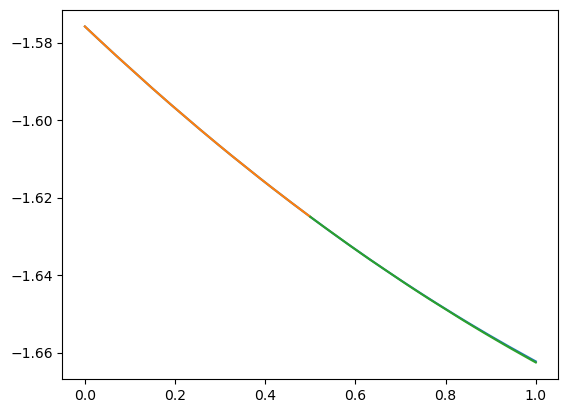

In [71]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import scipy.linalg

def _eigvalsh_to_eps(spectrum, cond=None, rcond=None):
    """Determine which eigenvalues are "small" given the spectrum.

    This is for compatibility across various linear algebra functions
    that should agree about whether or not a Hermitian matrix is numerically
    singular and what is its numerical matrix rank.
    This is designed to be compatible with scipy.linalg.pinvh.

    Parameters
    ----------
    spectrum : 1d ndarray
        Array of eigenvalues of a Hermitian matrix.
    cond, rcond : float, optional
        Cutoff for small eigenvalues.
        Singular values smaller than rcond * largest_eigenvalue are
        considered zero.
        If None or -1, suitable machine precision is used.

    Returns
    -------
    eps : float
        Magnitude cutoff for numerical negligibility.

    """
    if rcond is not None:
        cond = rcond
    if cond in [None, -1]:
        t = spectrum.dtype.char.lower()
        factor = {'f': 1E3, 'd': 1E6}
        cond = factor[t] * np.finfo(t).eps
    eps = cond * np.max(abs(spectrum))
    return eps


def _pinv_1d(v, eps=1e-5):
    """A helper function for computing the pseudoinverse.

    Parameters
    ----------
    v : iterable of numbers
        This may be thought of as a vector of eigenvalues or singular values.
    eps : float
        Values with magnitude no greater than eps are considered negligible.

    Returns
    -------
    v_pinv : 1d float ndarray
        A vector of pseudo-inverted numbers.

    """
    return np.array([0 if abs(x) <= eps else 1/x for x in v], dtype=float)


class _PSD:
    """
    Compute coordinated functions of a symmetric positive semidefinite matrix.

    This class addresses two issues.  Firstly it allows the pseudoinverse,
    the logarithm of the pseudo-determinant, and the rank of the matrix
    to be computed using one call to eigh instead of three.
    Secondly it allows these functions to be computed in a way
    that gives mutually compatible results.
    All of the functions are computed with a common understanding as to
    which of the eigenvalues are to be considered negligibly small.
    The functions are designed to coordinate with scipy.linalg.pinvh()
    but not necessarily with np.linalg.det() or with np.linalg.matrix_rank().

    Parameters
    ----------
    M : array_like
        Symmetric positive semidefinite matrix (2-D).
    cond, rcond : float, optional
        Cutoff for small eigenvalues.
        Singular values smaller than rcond * largest_eigenvalue are
        considered zero.
        If None or -1, suitable machine precision is used.
    lower : bool, optional
        Whether the pertinent array data is taken from the lower
        or upper triangle of M. (Default: lower)
    check_finite : bool, optional
        Whether to check that the input matrices contain only finite
        numbers. Disabling may give a performance gain, but may result
        in problems (crashes, non-termination) if the inputs do contain
        infinities or NaNs.
    allow_singular : bool, optional
        Whether to allow a singular matrix.  (Default: True)

    Notes
    -----
    The arguments are similar to those of scipy.linalg.pinvh().

    """

    def __init__(self, M, cond=None, rcond=None, lower=True,
                 check_finite=True, allow_singular=True):
        self._M = np.asarray(M)

        # Compute the symmetric eigendecomposition.
        # Note that eigh takes care of array conversion, chkfinite,
        # and assertion that the matrix is square.
        s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)

        eps = _eigvalsh_to_eps(s, cond, rcond)
        if np.min(s) < -eps:
            msg = "The input matrix must be symmetric positive semidefinite."
            raise ValueError(msg)
        d = s[s > eps]
        if len(d) < len(s) and not allow_singular:
            msg = ("When `allow_singular is False`, the input matrix must be "
                   "symmetric positive definite.")
            raise np.linalg.LinAlgError(msg)
        s_pinv = _pinv_1d(s, eps)
        U = np.multiply(u, np.sqrt(s_pinv))

        # Save the eigenvector basis, and tolerance for testing support
        self.eps = 1e3*eps
        self.V = u[:, s <= eps]

        # Initialize the eagerly precomputed attributes.
        self.rank = len(d)
        self.U = U
        self.log_pdet = np.sum(np.log(d))

        # Initialize attributes to be lazily computed.
        self._pinv = None

    def _support_mask(self, x):
        """
        Check whether x lies in the support of the distribution.
        """
        residual = np.linalg.norm(x @ self.V, axis=-1)
        in_support = residual < self.eps
        return in_support

    @property
    def pinv(self):
        if self._pinv is None:
            self._pinv = np.dot(self.U, self.U.T)
        return self._pinv

def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0
    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

ts = np.linspace(0., 1., 1001)
ls = 10

def mean(x):
    return np.zeros_like(x)

def cov(a,b):
    return np.exp(-(a-b)**2 / ls**2)

def mean_and_cov(xs):
    M = mean(xs)
    x0s, x1s = np.meshgrid(xs, xs)
    K = cov(x0s, x1s)
    return M, K

M, K = mean_and_cov(ts)
mvn = scipy.stats.multivariate_normal(M, K, allow_singular=True, seed=1)
sample_vals = mvn.rvs()


cond_ts = ts[ts<0.5]
cond_vs = sample_vals[ts<0.5]

def posterior_mean_and_cov(ts, cond_ts, cond_v):
    s11 = cov(*np.meshgrid(cond_ts, cond_ts))
    s12 = cov(*np.meshgrid(ts, cond_ts))
    
    #solved = (np.linalg.pinv(s11) @ s12).T
    solved = (_PSD(s11).pinv @ s12).T

    m2 = mean(ts) + (solved @ (cond_v - mean(cond_ts)))

    s22 = cov(*np.meshgrid(ts, ts))

    s2 = s22 - (solved @ s12)

    return m2, s2


cond_sample_ts = ts[ts>=0.5]

M, K = posterior_mean_and_cov(cond_sample_ts, cond_ts, cond_vs)
mvn_cond = scipy.stats.multivariate_normal(M, get_near_psd(K), allow_singular=True, seed=1)
cond_sample_vals = mvn_cond.rvs()

plt.plot(ts, sample_vals)
plt.plot(cond_ts, cond_vs)
plt.plot(cond_sample_ts, cond_sample_vals)
